In [1]:
import pandas as pd
import os, sys
from pathlib import Path

sys.path.append('../src/')

from main.classifier_cost_benefit_calculator import net_gain_curve, plot_net_gain_curve

# Load data

For this tutorial we use the credit card fraud detection dataset (downloaded from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud): 

In [2]:
df_undspl = pd.read_csv('data/creditcard_undersampled.csv').drop('Unnamed: 0', axis=1)

The original dataset is highly imbalanced: for the sake of simplicity we have undersampled the dataset in order to have a 2/1 ratio between class 0 (genuine transaction) and class 1 (fradulent transaction)

In [3]:
df_undspl.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [4]:
df_undspl.Class.describe()

count    1476.000000
mean        0.333333
std         0.471564
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Class, dtype: float64

# Data preparation 

Split the dataset into features and target, and into training and test:

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X, y = df_undspl.drop('Class', axis=1), df_undspl['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

In [7]:
X_train.shape

(988, 30)

In [8]:
X_test.shape

(488, 30)

# Model training 

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
lr = LogisticRegression()
lr = lr.fit(X_train, y_train)

### Performance on test set 

In [11]:
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score

In [12]:
y_score_lr = [i[1] for i in lr.predict_proba(X_test)]

In [13]:
print(f"AUC: {round(roc_auc_score(y_test.values, y_score_lr),3)} \n"
      f"Average precision: {round(average_precision_score(y_test.values, y_score_lr),3)} \n"
      f"Recall: {round(recall_score(y_test.values, [1 if i > 0.5 else 0 for i in y_score_lr]),3)}")

AUC: 0.978 
Average precision: 0.972 
Recall: 0.882


A simple logistic regression performs quite well on this dataset. Let's now see how the classifier-profit library can gives us some further insights.

## Problem 1: what cut-off should we use for the classifier?

### Standard approach: find cut-off that maximises F1 score 

A common approach is to ignore cost and gain associated with the confusion matrix and just maximising the F1 score. Let's try this approach here and see what cut-off we obtain.

In [14]:
import numpy as np
from sklearn.metrics import f1_score

In [15]:
cutoff_list = np.arange(0.0, 1.05, 0.05)

In [16]:
s = pd.Series(np.nan,index=cutoff_list)
for cutoff in cutoff_list:
    s.loc[cutoff] = f1_score(y_test, y_score_lr>=cutoff)

In [20]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'F1 score')

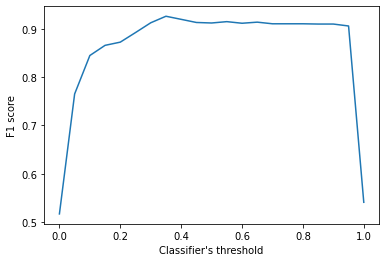

In [24]:
s.plot()
plt.xlabel("Classifier's threshold")
plt.ylabel("F1 score")

In [18]:
s.idxmax()

0.35000000000000003

The optimal cut-off we get when we simply maximise for F1 score is 0.35

### Net-gain approach: find cut-off that maximises net gain  

#### Scenario 1: cost of false positive much smaller than gain for true positive 

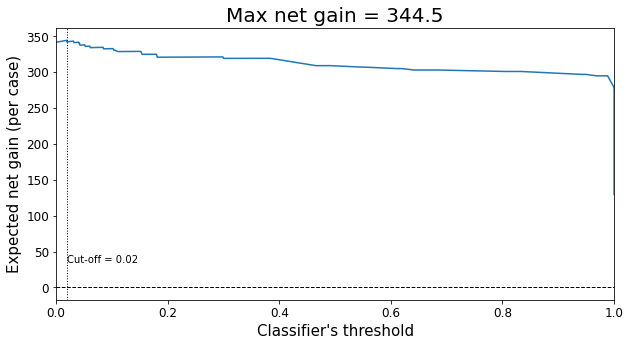

In [25]:
tp_gain = 1000.
fp_cost = 10.

expected_net_gain_series_lr, expected_net_gain_max_lr, optimal_threshold_lr = \
    net_gain_curve(y_test, y_score_lr, tp_gain, fp_cost)

plot_net_gain_curve(expected_net_gain_series_lr,figsize=(10,5))

Fraction of transactions above cut-off in test set:

In [30]:
(y_score_lr > optimal_threshold_lr).mean()

0.7336065573770492

Because the cost of false positive is relatively small compared to the gain for a true positive, the optimal cut-off is very loose: 0.02, meaning that we should flag as potentially fradulent all transactions that get a score above 0.02 (73% of transactions are like that in the test set).

#### Scenario 2: cost for false positive = gain for true positive 

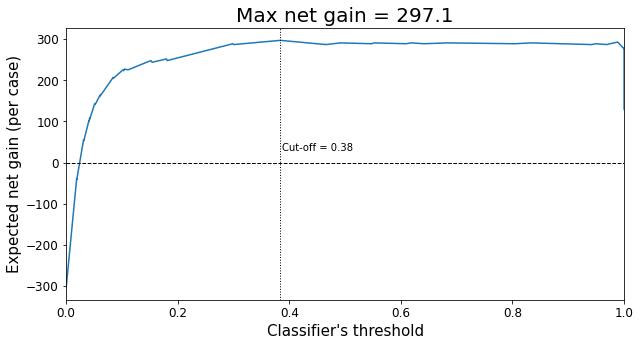

In [31]:
tp_gain = 1000.
fp_cost = 1000.

expected_net_gain_series_lr, expected_net_gain_max_lr, optimal_threshold_lr = \
    net_gain_curve(y_test, y_score_lr, tp_gain, fp_cost)

plot_net_gain_curve(expected_net_gain_series_lr,figsize=(10,5))

In [32]:
optimal_threshold_lr

0.3839312871435987

Fraction of transactions above cut-off in test set:

In [33]:
(y_score_lr > optimal_threshold_lr).mean()

0.3401639344262295

If cost for false positive equals gain for true positives, the optimal cut-off becomes stricter than in the previous scenario: we should flag a transaction as fradulent only if its score is above 0.38. In the test set this would include 34% of all transactions.

#### Scenario 3: cost for false positive >> gain for true positive 

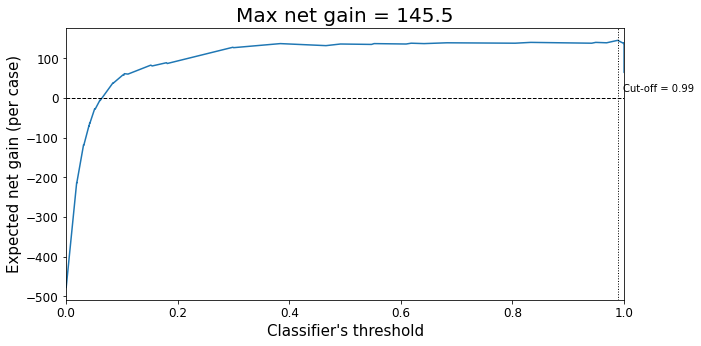

In [48]:
tp_gain = 500.
fp_cost = 1000.

expected_net_gain_series_lr, expected_net_gain_max_lr, optimal_threshold_lr = \
    net_gain_curve(y_test, y_score_lr, tp_gain, fp_cost)

plot_net_gain_curve(expected_net_gain_series_lr,figsize=(10,5))

Fraction of transactions above cut-off in test set:

In [49]:
(y_score_lr > optimal_threshold_lr).mean()

0.29508196721311475

If cost for false positive is much higher than cost of true positive, we are better off by significantly increasing the cut-off, so that we flag transactions as fradulent only if the classifier is very confident. Also notice how in this scenario the expected net gain is significantly lower than in the two previous scenarios: depending on the business context this may suggest that we are better off not using the classifier in the first place.

#### Scenario 4: cost for false positive = gain for true positive, but expected prior of class 1 in production is lower than in the test set (0.1 vs 0.333 in test set)

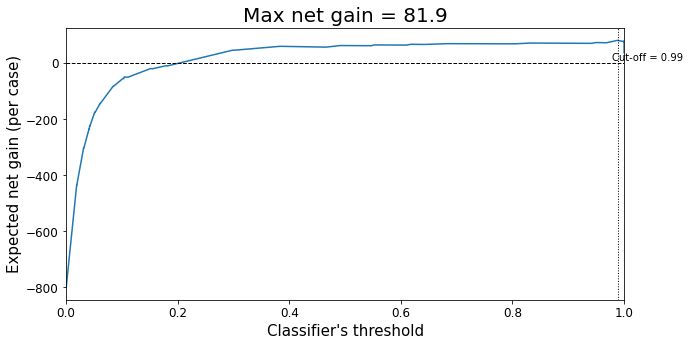

In [52]:
tp_gain = 1000.
fp_cost = 1000.
p_1 = 0.1

expected_net_gain_series_lr, expected_net_gain_max_lr, optimal_threshold_lr = \
    net_gain_curve(y_test, y_score_lr, tp_gain, fp_cost, p_1=p_1)

plot_net_gain_curve(expected_net_gain_series_lr,figsize=(10,5))

This scenario is similar to scenario 2, except that we assume the production data will have a lower prevalence of class 1 (fradulent transactions) than in the test set: as a consequence, even though it is still true that cost of false positive equals the gain of true positive, the gain of true positives is overall less important than in scenario 2 because there are fewer positive cases. Hence the optimal cut-off has increased to the same value recommended in scenario 3 (and expected max net gain has decreased even further).